# 크롤링 
-  https://www.kamis.or.kr/customer/main/main.do
- 농산물유통정보 사이트에서 날자별로 파값 (대파) 가격 크롤링. 
    - 주말과 공휴일에는 데이터가 없어서 데이터가 없는 날은 전 날의 가격으로 처리. 

- https://data.kma.go.kr/climate/StatisticsDivision/selectStatisticsDivision.do?pgmNo=158
- Selenium을 이용해 기상자료개방포털에서 매일 가격 크롤링. 
    - 기간을 하루 단위로 하지 않으면 sum 값이 나오기 때문에 기간을 하루 단위로 설정해서 크롤링.

In [1]:
# 하루 단위로 파가격 크롤링 
url = "https://www.kamis.or.kr/customer/price/product/item.do?action=priceinfo&regday={}&itemcategorycode=200&itemcode=246&kindcode=&productrankcode=&convert_kg_yn=N"

period = pd.date_range('2015.01.01', '2016.01.01', freq='D').strftime('%Y-%m-%d') 

price_df = pd.DataFrame()

for date in period: 
    urls = url.format(date)
    df = pd.read_html(urls, header=0)[3].iloc[:3,1:2]
    price_df = price_df.append(df.T)
price_df.reset_index(drop=True, inplace=True)
date_df = pd.DataFrame(period)
price_df= pd.concat([date_df, price_df], axis=1)
price_df.columns = ["date", "avg_price", "max_price", "min_price"]

price_df

KeyboardInterrupt: 

In [ ]:
from selenium import webdriver
from selenium.webdriver.support.select import Select
import time 

In [ ]:
def weather(): 
    
    driver = webdriver.Chrome('./chromedriver')
    driver.get("https://data.kma.go.kr/climate/StatisticsDivision/selectStatisticsDivision.do?pgmNo=158")

    region = """//*[@id="btnStn"]"""
    driver.find_element_by_xpath(region).click()

    time.sleep(2)
    choose_all = """//*[@id="ztree_1_check"]"""
    driver.find_element_by_id("ztree_1_check").click()

    finish = """//*[@id="sidetreecontrol"]/a"""
    driver.find_element_by_xpath(finish).click()

    # 일별 선택 
    day = """//*[@id="dataFormCd"]/option[1]"""
    driver.find_element_by_xpath(day).click()

    
    df = pd.DataFrame()
    
    years = range(2018, 2022)
    months = range(1, 13)
    dates = range(1, 32)
    
    for year in years:   
        
        # 시작하는 년도: 끝나는 년도와 동일
        startYear = Select(driver.find_element_by_xpath('//*[@id="startYear"]'))
        startYear.select_by_value(f'{year}')

        # 끝나는 년도: 시작하는 년도랑 동일 
        endYear = Select(driver.find_element_by_xpath('//*[@id="endYear"]'))
        endYear.select_by_value(f'{year}')
        
        for month in months: 
           # try:
                time.sleep(0.2)
                startMonth = """//*[@id="startMonth"]/option[{}]"""
                driver.find_element_by_xpath(startMonth.format(month)).click()

                time.sleep(0.2)
                endMonth = """//*[@id="endMonth"]/option[{}]"""
                driver.find_element_by_xpath(endMonth.format(month)).click()

                for date in dates:

                    time.sleep(0.2)
                    startDate= """//*[@id="startDay"]/option[{}]"""
                    driver.find_element_by_xpath(startDate.format(date)).click()

                    time.sleep(0.2)
                    endDate= """//*[@id="endDay"]/option[{}]"""
                    driver.find_element_by_xpath(endDate.format(date)).click()

                    time.sleep(0.2)
                    search = """//*[@id="schForm"]/div[3]/button"""
                    driver.find_element_by_xpath(search).click()

                    soup = BeautifulSoup(driver.page_source, "lxml")
                    #print(soup.find_all('table'))
                    table = soup.find_all('table')[1]
                    df1 = pd.read_html(str(table),header=0)
                    df = df.append(df1)

                    if date is None: 
                        print("day is none")

            #except: 
             #   df = df.append(np.nan)

        return df

In [12]:
datas = pd.read_excel('./datas/dataPA.xlsx', index_col='date', parse_dates=True)
datas.head()

,avg_price,max_price,min_price,avg_temp,max_temp,min_temp,rain_fall,paddy,field,total_field,cons_price,agr_price
date,,,,,,,,,,,,
2021-05-04,3600,4000,3000,15.7,19.6,11.0,19.8,NaN,NaN,NaN,NaN,NaN
2021-05-03,3812,4160,3000,14.0,21.3,6.2,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-02,3532,3700,3000,12.0,18.0,7.2,2.3,NaN,NaN,NaN,NaN,NaN
2021-05-01,3532,3700,3000,10.4,13.7,8.3,9.4,NaN,NaN,NaN,NaN,NaN
2021-04-30,3532,3700,3000,13.3,17.7,9.5,7.6,NaN,NaN,NaN,NaN,NaN


In [10]:
# rain_fall에 0이 가장 많았기 때문에 rain_Fall을 0으로 replace 해주었다. 
datas['rain_fall'] = datas['rain_fall'].replace(np.nan, 0)

# Moving Average 구하기
    - 당일의 날씨와 온도가 당일의 가격을 결정짓는다는 오류를 해결하기 위해 Moving average를 구해서 
    - 파종 기르기, 생육기, 수확, 그리고 유통 기간까지 합쳐서 5개월 단위로 rolling average를 잡고
    - 5개월 동안의 mean 날씨가 당일의 가격을 결정한다고 가정을 했습니다.
    - 가격을 뺀 모든 컬럼에 Moving Average를 구해 컬럼에 더해주었습니다.

<img src = "./pa_time.png">

In [2]:
datas = pd.read_excel('./datas/PAdata.xlsx', index_col='date', parse_dates=True)
datas.fillna(0).tail()

,avg_price,max_price,min_price,avg_temp,max_temp,min_temp,rain_fall,paddy,field,total_field,cons_price,agr_price,ma_price,ma_temp,ma_rain
date,,,,,,,,,,,,,,,
2015-01-05,1380,1500,1300,4.0,10.4,-2.7,4.3,0.0,0.0,0.0,99.77,99.74,1585.526316,1585.526316,1.292
2015-01-04,1320,1500,1100,2.7,9.9,-2.2,0.1,0.0,0.0,0.0,99.77,99.74,1578.026316,1578.026316,1.384
2015-01-03,1320,1500,1100,-2.0,4.5,-9.0,0.0,0.0,0.0,0.0,99.77,99.74,1570.263158,1570.263158,1.376
2015-01-02,1320,1500,1100,-3.5,1.0,-7.4,1.0,0.0,0.0,0.0,99.77,99.74,1562.500000,1562.500000,1.208
2015-01-01,1320,1500,1100,-4.6,-1.6,-7.1,2.6,0.0,0.0,0.0,99.77,99.74,1554.342105,1554.342105,0.792


In [3]:
# MinMax scaler 로 스케일을 해주었다. 
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
price = mms.fit_transform([datas["avg_price"]])
temperature = mms.fit_transform([datas["avg_temp"]])

In [4]:
# 파 재배 기간, 그리고 유통 기간을 5개월로 잡고 moving average를 구해보았다. 
datas['ma_price'] = datas['avg_price'].rolling(window=152).mean()
datas['ma_temp'] = datas['avg_temp'].rolling(window=152).mean()
datas['ma_min_temp'] = datas['min_temp'].rolling(window=152).mean()
datas['ma_max_temp'] = datas['max_temp'].rolling(window=152).mean()
datas['ma_rain'] = datas['rain_fall'].rolling(window=152).mean()

<AxesSubplot:xlabel='date'>

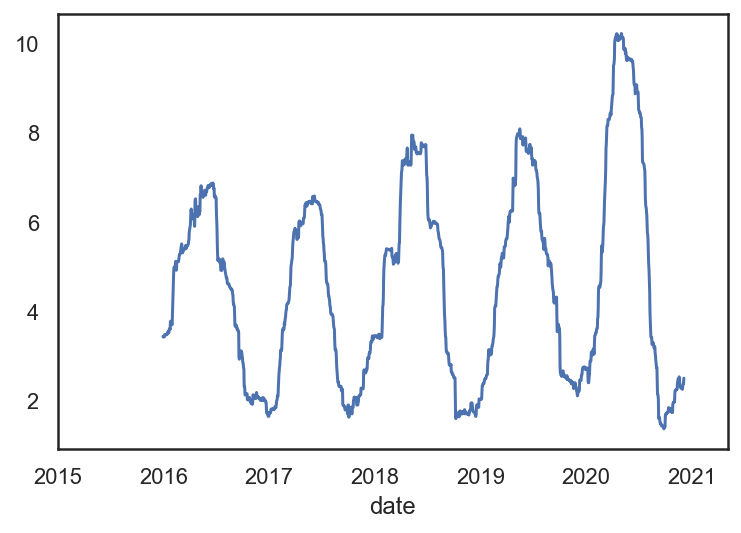

In [5]:
datas['ma_rain'].plot()

In [36]:
datas.head(1)

,avg_price,max_price,min_price,avg_temp,max_temp,min_temp,rain_fall,paddy,field,total_field,cons_price,agr_price,ma_price,ma_temp,ma_rain,ma_min_temp,ma_max_temp
date,,,,,,,,,,,,,,,,,
2020-12-04,2682,3000,2500,1.2,6.8,-3.5,1.1,55.0,1461.0,1517.0,0.5,9.7,NaN,NaN,NaN,NaN,NaN


In [37]:
# moving average data 저장
ma.to_csv(r'moving_data_final.csv')

<AxesSubplot:xlabel='date'>

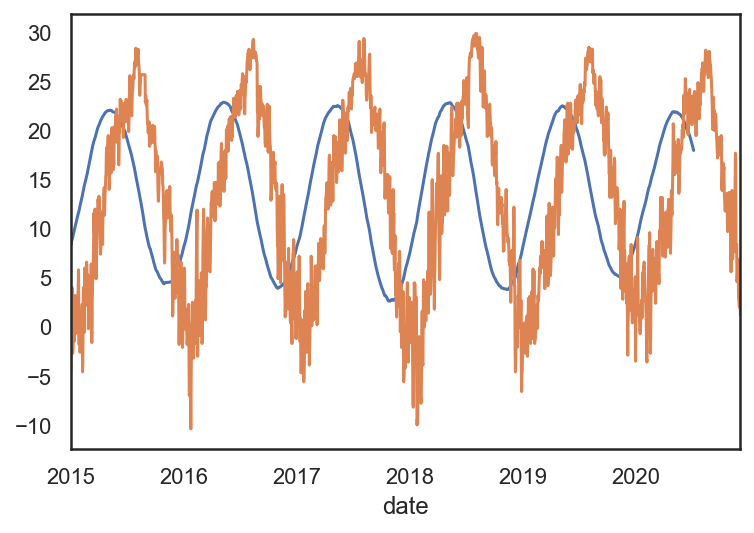

In [38]:
# Moving average temperature와 그냥 temperature의 시각화
datas['ma_temp'].plot()
datas['avg_temp'].plot()

In [51]:
data = datas['2020-12-04':]
data.head(2)

,avg_price,max_price,min_price,avg_temp,max_temp,min_temp,rain_fall,paddy,field,total_field,cons_price,agr_price,ma_price,ma_temp,ma_rain,ma_min_temp,ma_max_temp
date,,,,,,,,,,,,,,,,,
2020-12-04,2682,3000,2500,1.2,6.8,-3.5,1.1,55.0,1461.0,1517.0,0.5,9.7,NaN,NaN,NaN,NaN,NaN
2020-12-03,2682,3000,2500,2.7,7.7,-1.2,0.5,55.0,1461.0,1517.0,0.5,9.7,NaN,NaN,NaN,NaN,NaN


In [40]:
data.to_excel(r"ma_data.xlsx")

In [41]:
# 필요한 컬럼만 심플한 데이터프레임으로 만들어주기

In [44]:
simple_data = data[["avg_price", "ma_temp", "ma_min_temp", "ma_max_temp", "ma_rain"]]
simple_data.()

,avg_price,ma_temp,ma_min_temp,ma_max_temp,ma_rain
date,,,,,
2020-12-04,2682,NaN,NaN,NaN,NaN
2020-12-03,2682,NaN,NaN,NaN,NaN
2020-12-02,2572,NaN,NaN,NaN,NaN
2020-12-01,2612,NaN,NaN,NaN,NaN
2020-11-30,2702,NaN,NaN,NaN,NaN


# Linear Regression으로 예측

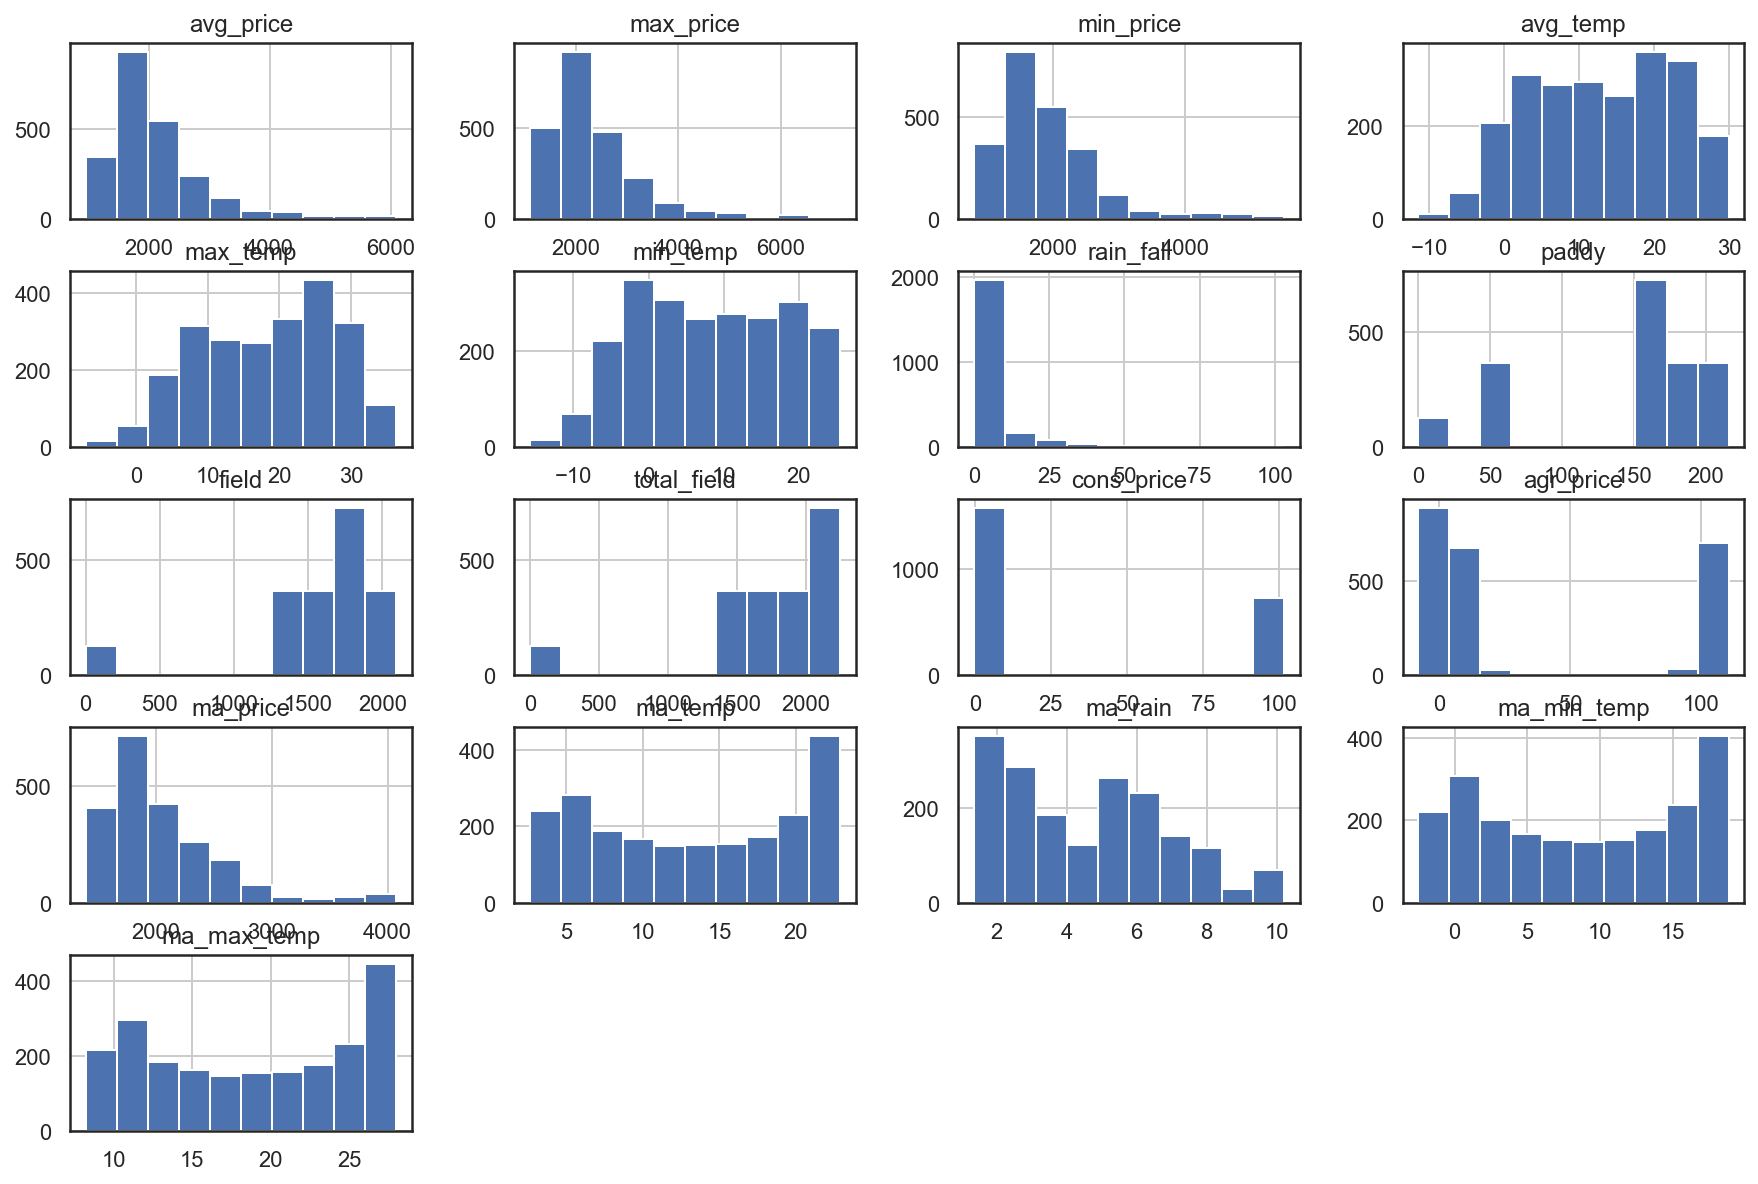

In [6]:
# 분포도를 확인해보았다. 
import matplotlib.pyplot as plt 
datas.hist(bins=10, figsize=(15,10))
plt.show()

In [ ]:
# X, y split

In [48]:
X = d[["ma_temp", "agr_price", "total_field", "rain_fall"]]
y = pd.DataFrame(d['ma_price'])

In [49]:
y = d.astype({'ma_price' : 'int'})
y = y["ma_price"]
y

date
2020-12-04    4074
2020-12-03    4068
2020-12-02    4060
2020-12-01    4054
2020-11-30    4049
              ... 
2015-01-05    1585
2015-01-04    1578
2015-01-03    1570
2015-01-02    1562
2015-01-01    1554
Name: ma_price, Length: 2165, dtype: int64

In [50]:
from sklearn.preprocessing import StandardScaler 

sc = StandardScaler()
X_sc = sc.fit_transform(X)

TypeError: float() argument must be a string or a number, not 'AxesSubplot'

In [23]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression 

models = []
models.append(('RandomForest Regressor (평균 제곱근오차, MSE):', RandomForestRegressor()))
models.append(('Linear Regressor', LinearRegression()))

In [ ]:
from sklearn.model_selection import KFold, cross_val_score, KFold

results = []
names = []

for name, model in models: 
    kfold = KFold(n_splits=5, random_state=13, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold,)
    results.append(cv_results)
    names.append(name)
    
    print(name, cv_results.mean(), cv_results.std())

In [ ]:
# Price = B1*Temp+B0

In [ ]:
features = ["avg_temp"]
target = 'avg_price'

X = d[features]
y = d[target].values

In [ ]:
print(X.shape)
print(y.shape)

In [ ]:
from sklearn import linear_model
ols = linear_model.LinearRegression()
model = ols.fit(X, y)

In [ ]:
model.coef_

In [ ]:
model.intercept_

In [ ]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [ ]:
# Price = -4.49*Temp - 2063.38

In [ ]:
model.score(X, y)

In [ ]:
x_pred = np.array([15])
x_pred = x_pred.reshape(-1, len(features))

In [ ]:
model.predict(x_pred)

In [ ]:
x_pred = np.linspace(0, 40, 200)
x_pred = x_pred.reshape(-1, len(features))
y_pred = model.predict(x_pred)

In [ ]:
x_pred = sc.fit_transform(x_pred)
y_pred = y_pred.reshape(-1, len(features))
y_pred = sc.fit_transform(y_pred)
X = sc.fit_transform(X)
y = y.reshape(-1, len(features))
y = sc.fit_transform(y)

In [ ]:
import matplotlib.pyplot as plt 

plt.style.use('default')
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(7, 3.5))

ax.plot(x_pred, y_pred, color='k', label='Regression model')
ax.scatter(X, y, edgecolor='k', facecolor='grey', alpha=0.7, label='sample data')
ax.set_ylabel('Price', fontsize=14)
ax.set_xlabel('Temperature', fontsize=14)
ax.legend(facecolor='white', fontsize=11)
ax.text(0.55, 0.15, '$y = %.2f x_1 - %.2f $' % (model.coef_[0], abs(model.intercept_)), fontsize=17, transform=ax.transAxes)

fig.tight_layout()

In [ ]:
features = ["rain_fall"]
target = 'avg_price'

X = d[features]
y = d[target].values
y = y.reshape(-1, len(features))

model = ols.fit(X, y)
model.score(X, y)

x_pred = np.linspace(0, 40, 200)
x_pred = x_pred.reshape(-1, len(features))
y_pred = model.predict(x_pred)
y_pred = y_pred.reshape(-1, len(features))

x_pred = sc.fit_transform(x_pred)
y_pred = sc.fit_transform(y_pred)
X = sc.fit_transform(X)
y = sc.fit_transform(y)

plt.style.use('default')
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(7, 3.5))

ax.plot(x_pred, y_pred, color='k', label='Regression model')
ax.scatter(X, y, edgecolor='k', facecolor='grey', alpha=0.7, label='sample data')
ax.set_ylabel('Price', fontsize=14)
ax.set_xlabel('Rain fall', fontsize=14)
ax.legend(facecolor='white', fontsize=11)
ax.text(0.55, 0.15, '$y = %.2f x_1 - %.2f $' % (model.coef_[0], abs(model.intercept_)), fontsize=17, transform=ax.transAxes)

fig.tight_layout()

In [ ]:
# multi-linear model
# Price = B1*temp + B2*paddy ...

In [ ]:
features = ["ma_temp", "agr_price", "total_field", "rain_fall"]
target = 'ma_price'

X = d[features].values.reshape(-1, len(features))
y = d[target].values

ols = linear_model.LinearRegression()
model = ols.fit(X, y)

In [ ]:
model.coef_

In [ ]:
model.intercept_

In [ ]:
# Price = -15.606*temp + 1.52*agr_price - 1.103*total_field +3.87rainfall + 4315.04

In [ ]:
model.score(X, y)

In [ ]:
import statsmodels.api as sm 

In [ ]:
lm = sm.OLS(y_test, X_test).fit()
lm.summary()

# x1 = "ma_temp"
# x2 = "agr_price"
# x3 = "total_field"
# x4 = "rain_Fall"

# dep var y = "ma_price"

In [ ]:
# https://cnvrg.io/random-forest-regression/?gclid=CjwKCAjw1uiEBhBzEiwAO9B_HWm518q_Yw6MRaBCfzrAVqcXF_3hHhzI7IrIHtmT26UHuwwUNMlfvhoCiocQAvD_BwE

In [ ]:
from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor()

In [ ]:
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)

In [ ]:
sc.fit_transform(X)
sc.fit_transform([y])

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

In [ ]:
random_forest_tuning = RandomForestRegressor(random_state = 13)
param_grid = {
    'n_estimators' : [100, 200, 500],
    'max_features' : ['auto', 'sqrt', 'log2'], 
    'max_depth' : [4,5,6,7,8],
    'criterion' : ['mse', 'mae'],
}
GSCV = GridSearchCV(estimator=random_forest_tuning, param_grid=param_grid, cv=5)
GSCV.fit(X_train, y_train)
GSCV.best_params_

In [ ]:
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
random_forest = RandomForestRegressor(random_state = 13)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
print('MAE: ', mean_absolute_error(y_test, y_pred)) # 평균절대오차: 실제값과 예측 값과의 차이. 모든 절대 오차의 평균
print('MSE: ', mean_squared_error(y_test, y_pred)) # 평균제곱 오차: 오차의 제곱에 대한 평균을 취한 값

In [ ]:
from math import sqrt 
print('RMSE: ', sqrt(mean_squared_error(y_test, y_pred)))

In [ ]:
random_forest_out_of_bag = RandomForestRegressor(oob_score=True)
random_forest_out_of_bag.fit(X_train, y_train)
print(random_forest_out_of_bag.oob_score_) 

In [ ]:
plt.scatter(X_test['ma_temp'].values, y_test, color = 'red')
plt.scatter(X_test['ma_temp'].values, y_pred, color = 'green')
plt.title('Random Forest Regression')
plt.xlabel('moving_temp')
plt.ylabel('Price')
plt.show() 

In [ ]:
from sklearn import tree 
fn=data.feature_names
cn=data.target
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,4), dpi=800)
tree.plot_tree(random_forest.estimators_[0],
              feature_names=fn, 
              class_names=cn, 
              filled=True);

In [ ]:
# walk-forward validation
# https://www.youtube.com/watch?v=4rikgkt4IcU

In [ ]:
# transform into supervised learning problem

In [ ]:
df = datas[['avg_price']].copy()

In [ ]:
df.head()

In [ ]:
df["target"] = df.avg_price.shift(-1)
df.head()

In [ ]:
df.dropna(inplace=True)

In [ ]:
def train_test_split(data, perc):
    data = data.values
    n = int(len(data) * (1 - perc))
    return data[:n], data[n:]

In [ ]:
train, test = train_test_split(df, 0.2)

In [ ]:
print(len(df))
print(len(train))
print(len(test))

In [ ]:
X = train[:, :-1]
y = train[:, -1]

In [ ]:
from xgboost import XGBRegressor

In [ ]:
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(X, y)

In [ ]:
test[0] #실제 데이터 

In [ ]:
val = np.array(test[0, 0]).reshape(1, -1)

pred = model.predict(val)
print(pred[0]) # 맞춘 데이터

In [ ]:
# Predict 

In [ ]:
def xgb_predict(train, val):
    train = np.array(train)
    X, y = train[:, :-1], train[:, -1]
    model = XGBRegressor(objective="reg:squarederror", n_estimators=1000)
    model.fit(X, y)
    
    val = np.array(val).reshape(1, -1)
    pred = model.predict(val)
    return pred[0]

In [ ]:
xgb_predict(train, test[0, 0])

# Walk forward Validation
- Time series이기 때문에 walk forward validation으로 predict를 해보았다. 
- price 값만 가지고 현재의 가격과 다음날의 가격을 더한 컬럼을 만들어서 다음 컬럼을 예측하는 것.

In [24]:
# walk-forward validation - one step forward prediction. 
# use train dataset, predict one step into the future, add that to trainset, retrain, predict second item, and add to trainset ...etc
# evaluate with RMSE metric

In [25]:
from sklearn.metrics import mean_squared_error

def validate(data, perc):
    predictions = []
    
    train, test = train_test_split(data, perc)
    
    history = [x for x in train]
    
    for i in range(len(test)):
        test_X, test_y = test[i, :-1], test[i, -1]
        
        pred = xgb_predict(history, test_X[0])
        predictions.append(pred)
        
        history.append(test[i])
        
    error = mean_squared_error(test[:, -1], predictions, squared=False)
    
    return error, test[:, -1], predictions

In [26]:
df = df.dropna()

In [27]:
%%time
rmse, y, pred = validate(df, 0.2)

print(rmse)

TypeError: Singleton array array(0.2) cannot be considered a valid collection.

In [28]:
# 타임 시리즈 데이터를 다루기 좋은 형태로 바꾸기
# https://machinelearningmastery.com/random-forest-for-time-series-forecasting/#:~:text=Random%20Forest%20can%20also%20be,a%20supervised%20learning%20problem%20first.&text=Random%20Forest%20is%20an%20ensemble,classification%20and%20regression%20predictive%20modeling.
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    agg = pd.concat(cols, axis=1)
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

# train test split
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
    train = np.asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    train, test = train_test_split(data, n_test)
    history = [x for x in train]
    for i in range(len(test)):
        testX, testy = test[i, :-1], test[i, -1]
        yhat = random_forest_forecast(history, testX)
        predictions.append(yhat)
        history.append(test[i])
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

In [29]:
series = datas
values = series.values
data = series_to_supervised(values, n_in=6)
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)

NameError: name 'RandomForestRegressor' is not defined

NameError: name 'yhat' is not defined

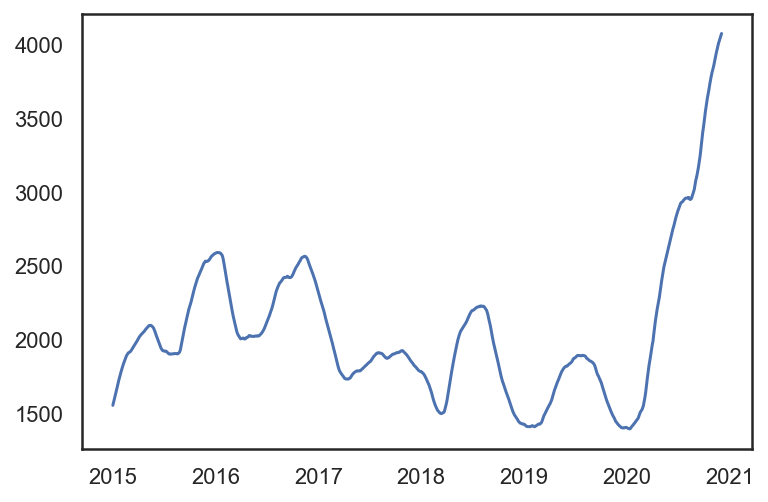

In [30]:
from matplotlib import pyplot
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

In [ ]:
datas['avg_price'].plot(figsize=(15,8))
datas['avg_price'].rolling(window=150).mean().plot()

In [ ]:
data = pd.read_csv(r'moving_average.csv')
data.head()

In [ ]:
data = data.fillna(0)
data.head()

In [ ]:
data.to_excel(r'moving_average.xlsx')
data.to_csv(r'moving_average.csv')